# Sediment production, transport and deposition in both continental and marine environments

This notebook shows a run example of the `marine_model` provided in [fastscape](https://fastscape.readthedocs.io/en/latest/).

In [1]:
import numpy as np
import xsimlab as xs
import matplotlib.pyplot as plt
import fastscape

%matplotlib inline

In [2]:
print('xarray-simlab version: ', xs.__version__)
print('fastscape version: ', fastscape.__version__)

xarray-simlab version:  0.4.1
fastscape version:  0.1.0beta


## Import and inspect the model

In [3]:
from fastscape.models import marine_model

In [4]:
marine_model

<xsimlab.Model (22 processes, 29 inputs)>
grid
    shape                   [in] ('shape_yx',) nb. of grid nodes in...
    length                  [in] ('shape_yx',) total grid length in...
fs_context
boundary
    status                  [in] () or ('border',) node status at b...
uplift
    x_position              [in] position of the clip plane along t...
    rate_left               [in] uplift rate of the left block
    rate_right              [in] uplift rate of the right block
tectonics
init_topography
    elevation_left          [in] elevation on the left side of the ...
    x_right                 [in] location of the scarp's right limi...
    elevation_right         [in] elevation on the right side of the...
    x_left                  [in] location of the scarp's left limit...
surf2erode
init_erosion
init_bedrock
active_layer
diffusion
    diffusivity_soil        [in] () or ('y', 'x') soil (sediment) d...
    diffusivity_bedrock     [in] () or ('y', 'x') bedrock diffusivity
flow

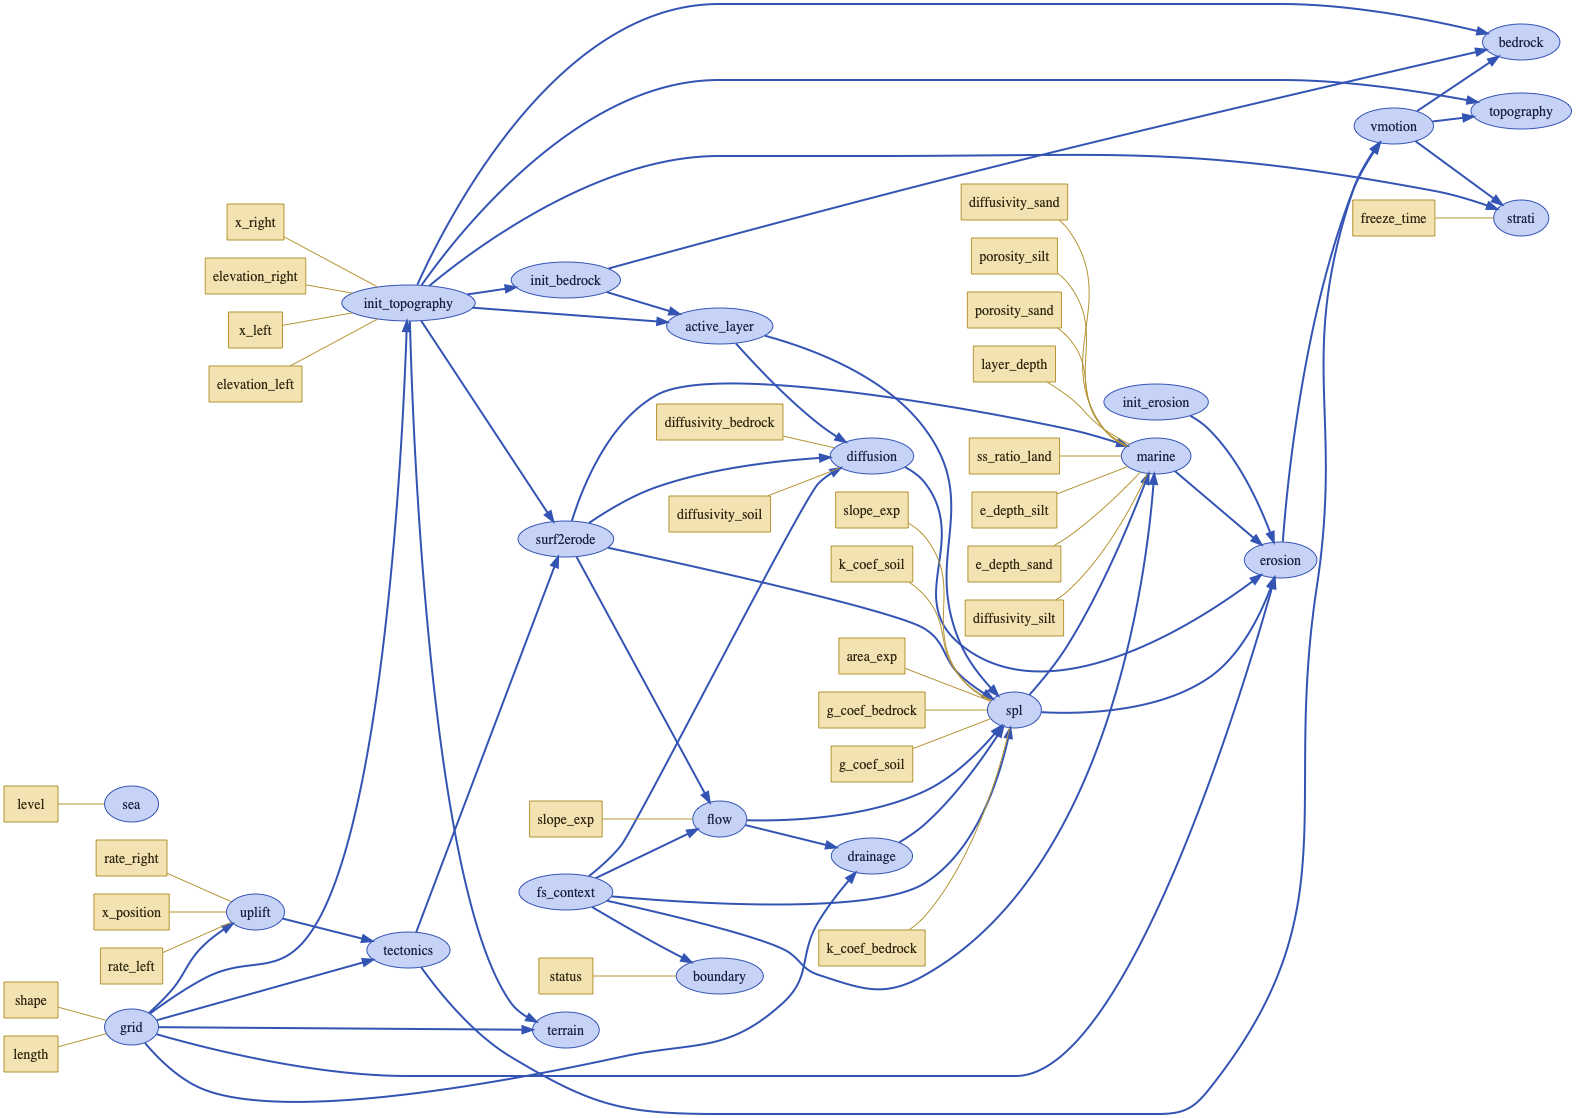

In [5]:
marine_model.visualize(show_inputs=True)

## Model setup

In [6]:
in_ds = xs.create_setup(
    model=marine_model,
    clocks={
        'time': np.arange(0, 4e6 + 1e3, 1e3),
        'out': np.arange(0, 4e6 + 2e5, 2e5),
    },
    master_clock='time',
    input_vars={
        'grid__shape': [101, 101],
        'grid__length': [4e5, 4e5],
        'boundary__status': ['fixed_value', 'core', 'looped', 'looped'],
        'init_topography': {
            'x_left': 0,
            'x_right': 2.5e5,
            'elevation_left': -1e3,
            'elevation_right': 0.
        },
        'uplift': {
            'x_position': 2.5e5,
            'rate_left': 0.,
            'rate_right': 3e-4
        },
        'flow__slope_exp': 1.,
        'spl': {
            'k_coef_bedrock': 1e-5,
            'k_coef_soil': 1e-5,
            'g_coef_bedrock': 1.,
            'g_coef_soil': 1.,
        },
        'diffusion': {
            'diffusivity_bedrock': 1e-2,
            'diffusivity_soil': 1e-2
        },
        'marine': {
            'ss_ratio_land': 0.5,
            'porosity_sand': 0.,
            'porosity_silt': 0.,
            'e_depth_sand': 1e3,
            'e_depth_silt': 1e3,
            'diffusivity_sand': 5e2,
            'diffusivity_silt': 2.5e2,
            'layer_depth': 1e2,
        },
        'strati': {
            'freeze_time': ('horizon', np.linspace(0, 4e6, 5))
        }
    },
    output_vars={
        'topography__elevation': 'out',
        'strati__elevation': 'out',
        'marine__ss_ratio_sea': 'out',
    }
)

in_ds

<xarray.Dataset>
Dimensions:                           (border: 4, horizon: 5, out: 21, shape_yx: 2, time: 4001)
Coordinates:
  * time                              (time) float64 0.0 1e+03 ... 4e+06
  * out                               (out) float64 0.0 2e+05 ... 3.8e+06 4e+06
Dimensions without coordinates: border, horizon, shape_yx
Data variables:
    spl__slope_exp                    int64 1
    sea__level                        float64 0.0
    spl__area_exp                     float64 0.4
    grid__shape                       (shape_yx) int64 101 101
    grid__length                      (shape_yx) float64 4e+05 4e+05
    boundary__status                  (border) <U11 'fixed_value' ... 'looped'
    init_topography__x_left           int64 0
    init_topography__x_right          float64 2.5e+05
    init_topography__elevation_left   float64 -1e+03
    init_topography__elevation_right  float64 0.0
    uplift__x_position                float64 2.5e+05
    uplift__rate_left            

## Run the model

In [7]:
with xs.monitoring.ProgressBar():
    out_ds = in_ds.xsimlab.run(model=marine_model)

In [8]:
out_ds

<xarray.Dataset>
Dimensions:                           (border: 4, horizon: 5, out: 21, shape_yx: 2, time: 4001, x: 101, y: 101)
Coordinates:
  * border                            (border) <U6 'left' 'right' 'top' 'bottom'
  * horizon                           (horizon) int64 0 1 2 3 4
  * out                               (out) float64 0.0 2e+05 ... 3.8e+06 4e+06
  * time                              (time) float64 0.0 1e+03 ... 4e+06
  * x                                 (x) float64 0.0 4e+03 ... 3.96e+05 4e+05
  * y                                 (y) float64 0.0 4e+03 ... 3.96e+05 4e+05
Dimensions without coordinates: shape_yx
Data variables:
    boundary__status                  (border) <U11 'fixed_value' ... 'looped'
    diffusion__diffusivity_bedrock    float64 0.01
    diffusion__diffusivity_soil       float64 0.01
    flow__slope_exp                   float64 1.0
    grid__length                      (shape_yx) float64 4e+05 4e+05
    grid__shape                       (shape_

## Plot the outputs (topography and stratigraphic horizons)

In [9]:
import hvplot.xarray
import holoviews as hv
from xshade import hillshade


ss_ratio_plot = out_ds.marine__ss_ratio_sea.hvplot.image(
    x='x', y='y', clim=(0, 1),
    width=550, height=450,
    cmap=plt.cm.viridis_r, groupby='out'
)

hillshade_plot = hillshade(out_ds, 'out').hvplot.image(
    x='x', y='y', cmap=plt.cm.gray, alpha=0.5,
    colorbar=False, hover=False, groupby='out'
)

yhorizons_plot = out_ds.strati__elevation.sel(y=2e5).hvplot.line(
    by='horizon', groupby='out', ylim=(-1000, 1000),
    width=550, legend='bottom_right',
)

hv.Layout((ss_ratio_plot * hillshade_plot) + yhorizons_plot).cols(1)

:Layout
   .DynamicMap.I  :DynamicMap   [out]
      :Overlay
         .Image.I  :Image   [x,y]   (marine__ss_ratio_sea)
         .Image.II :Image   [x,y]   (hillshade)
   .DynamicMap.II :DynamicMap   [out]
      :NdOverlay   [horizon]
         :Curve   [x]   (strati__elevation)